# Example *ppar* for NSCL/FRIB data

In [1]:
import numpy as np

import ppar as ppar

from scipy.sparse import load_npz,csr_matrix

Load experimental data for the comparison of the convoluted theoretical momentum distributions.

In [2]:
exp_ppar_distr = ppar.spectrum.__new__(ppar.spectrum)

exp_ppar_distr.centers = np.loadtxt('centers_36Ca_2.txt')
exp_ppar_distr.edges   = np.loadtxt('edges_36Ca_2.txt')
exp_ppar_distr.values  = load_npz('values_36Ca_2.npz').toarray()
exp_ppar_distr.ndim    = exp_ppar_distr.values.ndim

print(exp_ppar_distr.centers.shape)
print(exp_ppar_distr.edges.shape)
print(exp_ppar_distr.values.shape)

(1000,)
(1001,)
(1000, 100000)


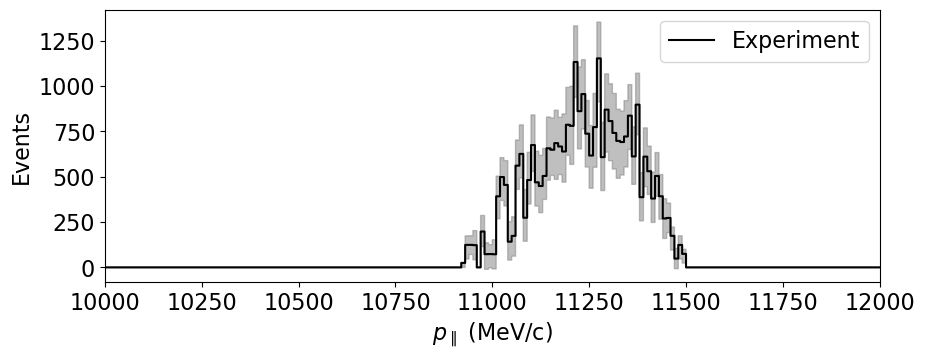

In [3]:
_,_ = exp_ppar_distr.plot(xlim=[10000,12000])

## Parameters reaction

Definition of the reaction setting. 
For the beam and the reaction product a name (for outout and plots) and 
proton number Z, mass number A, and the atomic mass in $u$ are needed.
The ion mass is calculated internally.
A charge state can be specified using the key 'q'; 
a fully stripped ion is assumed otherwise.

If the target is not isotopically pure, 'mass' must be the molar mass of the natural element.
The target thickness and density are given in mg/cm$^2$ and g/cm$^3$, respectively.

In [4]:
beam       = {'name':'38Ca','Z':20,'A':38,'mass':37.9763186}
product    = {'name':'36Ca','Z':20,'A':36,'mass':35.9930872}

target     = {'name': '9Be','Z': 4,'A': 9,'mass': 9.0121821,
              'thickness':188,'density':1.848}

## Initialization

In order to initialize a *ppar* object the above defined dictionaries 
with information on the involved nuclei are needed (in logical order beam - target- product).

In addition, magnetic rigidities for Segment 7 (BTS33) and Segment 8 (BTS34)
of the S800 magnetic spectrometer are needed - 
for the setting with unreacted beam and the reaction product centered in the focal plane.
They can either be given in the form of dictionaries with keys 'before' (BST33)
and 'after' (BTS34) or the Barney files (beamline save sets) can be handed over.

The 'verbose' keyword argument (default *True*) controls the verbosity of the entire code.
If set to *True* it outputs a summary of all inputs and derived quantities for inspection.

In [5]:
ppar_test = ppar.ppar_NSCL(beam,target,product,
                           Brho_unreac={'before':2.31430,'after':1.99005},
                           Brho_reac  ='2019_11_14_12h45m22.txt',
                           verbose=True,
                           )

##############################
#       ppar convolver       #
#            NSCL            #
##############################

########################
#  Input               #
########################

                    Beam           Target         Product        
---------------------------------------------------------
name                38Ca           9Be            36Ca           
A                   38             9              36             
Z                   20             4              20             
mass (u)            37.9763        9.0122         35.9931        
ion mass (u)        37.9653        9.0100         35.9821        
density (g/cm3)                    1.8480                        
d (mg/cm2)                         188.0                         
d (µm)                             1017.3                        

########################
#  Kinematics          #
########################

Reaction:	9Be(38Ca,36Ca)9Be

	                    Seg7/BTS33     Seg8/

## Correction of velocity

If the momentum distribution of the reaction product is not well centered in the S800
the velocity deduced from the magnetic rigidity is not correct.
Since it is important for the transformation to the laboratory system a correction is recommended.

The functions are completely analoguous to the ones described in detail below 
for the fit of the $\gamma$-gated momentum distribution from the unreacted beam setting.
Since not the entire distribution but only the peak has to be described,
only the higher-momentum part of the fit function given below is used.
Thus, only four fit parameters are needed.

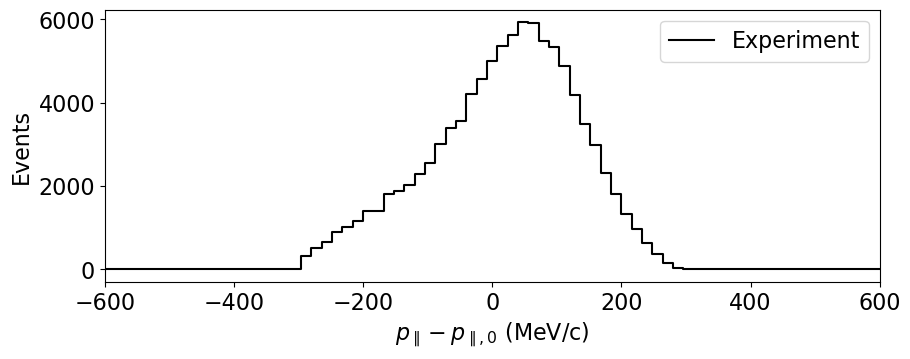

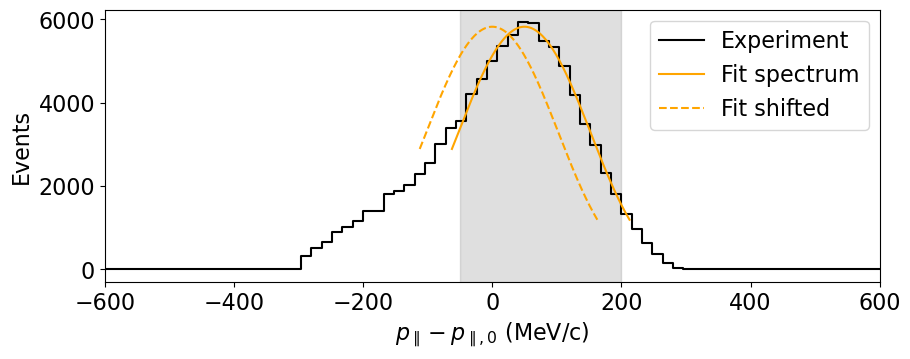

In [6]:
ppar_test.load_reacted(file='hist_reaction.root',
                       hist='S800_ppar/ppar-ptot0_MeV_c;1',
                       rebin=8
                      )

ppar_test.plot_reacted(rebin=True,xlim=[-600,600]);

x0 = [10000,15,50,15]

ppar_test.fit_reacted(fit_range=[-50,200],x0=x0)
ppar_test.plot_reacted(rebin=True,xlim=[-600,600]);

In [7]:
ppar_test.fit_res_reac

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 406.3459540913676
             x: [ 6.707e+03  2.016e+02  4.985e+01  6.879e+00]
           nit: 1862
          nfev: 3056
 final_simplex: (array([[ 6.707e+03,  2.016e+02,  4.985e+01,  6.879e+00],
                       [ 6.707e+03,  2.016e+02,  4.985e+01,  6.879e+00],
                       ...,
                       [ 6.707e+03,  2.016e+02,  4.985e+01,  6.879e+00],
                       [ 6.707e+03,  2.016e+02,  4.985e+01,  6.879e+00]],
                      shape=(5, 4)), array([ 4.063e+02,  4.063e+02,  4.063e+02,  4.063e+02,
                        4.063e+02]))

The effect of the correction on the kinematic quantities can be observed
by comparing *kin_reac* to the output from the initialization
(which calculated all quantities from the rigidity setting of BTS34 of the S800).

In [8]:
ppar_test.kin_reac

{'before': {'Brho': 2.3143,
  'nucl': '38Ca',
  'p': 13876.193710987998,
  'TKE': np.float64(2624.9278523096073),
  'gamma': np.float64(1.07422494546941),
  'beta': np.float64(0.3652646442940545)},
 'after': {'Brho': np.float64(1.8799134029615383),
  'nucl': '36Ca',
  'p': np.float64(11271.67719801968),
  'TKE': np.float64(1844.5542888490018),
  'gamma': np.float64(1.0550331836337192),
  'beta': np.float64(0.31875398176552305)}}

## Stopping

The next step is the estimation of differences in momentum of the reaction product
due to different reaction positions in the target.
For simplicity the two most extreme cases are considered:

- reaction at the beginning of the target, i.e. stopping of a nucleus of type product and
- reaction at the end of the target, i.e. stopping of a nucleus of type beam.

It is assumed that the reaction does not change the energy per nucleon.
The calculations run Atima in the background and exploit the connection between 
the total kinetic energy of a particle and its range within the target material.
Two methods are available through the keyword argument 'method' (default *bw*):

- *bw* calculates the momentum difference starting from BTS34 (thus the name backward) and
- *fw* calculates the momentum difference starting from BTS33 (thus the name forward).

In order to minimize the total number of Atima calls *ppar* uses interpolation.
Using the 'threshold' keyword it can be requested that a data point 
from an actual Atima calculation is available at most 'threshold' µm 
away from the exact solution. 

In [9]:
ppar_test.calc_stopping(threshold=5,method='bw')

########################
#  Stopping            #
########################

Stopping of 38Ca in 188.0 mg/cm2 9Be: 
	Found solution within 5.0 µm after 7(9) iterations(Atima calls).

Stopping of 36Ca in 188.0 mg/cm2 9Be: 
	Found solution within 5.0 µm after 8(10) iterations(Atima calls).



A plot of the obtained data points and the interpolation can be obtained
through the *plot_stopping* method.
It can be saved using the *save=filename.file* keyword argument.

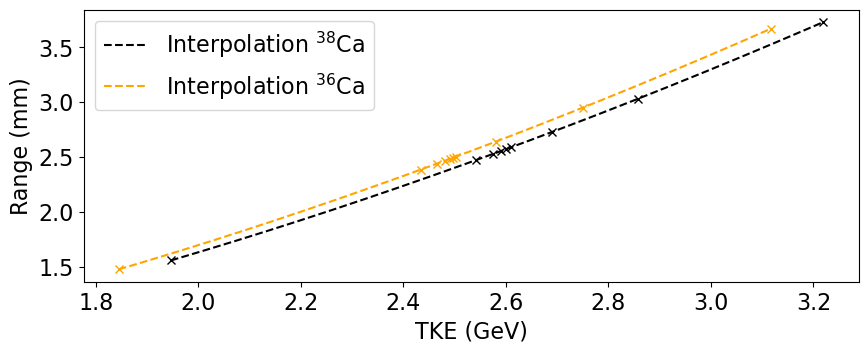

In [10]:
ppar_test.plot_stopping();

The results from the stopping calculations and the symmetrized momentum differences 
can be found in *stopping* and *p_range*, respectively.

In [11]:
#print(ppar_test.stopping['data'])
#print(ppar_test.stopping['interpol'])
print(ppar_test.p_range)

[-44.41764711  44.41764711]


## Shape of $\gamma$-gated $p_{\parallel}$ distribution of unreacted beam

The shape of the $\gamma$-gated ($E_{\gamma}\geq1$ MeV)
is extracted from experimental data.
This requires loading a histogram from a .root file and extracting its data 
via the *load_unreacted* method.
In addition, it can be rebinned using the *rebin* keyword (default *1*).

The obtained spectrum can be displayed using the *plot_unreacted* method.
It supports keyword arguments 'xlim' and 'ylim' for the horizontal and vertical scaling, respectively,
'rebin' (default *True*) to display the rebinned spectrum, 
'log' (default *False*) to use a logarithmic vertical scale,
'rescale' (default *False*) for rescaling the momentum axis to GeV/c 
and 'save' for saving the entire figure.

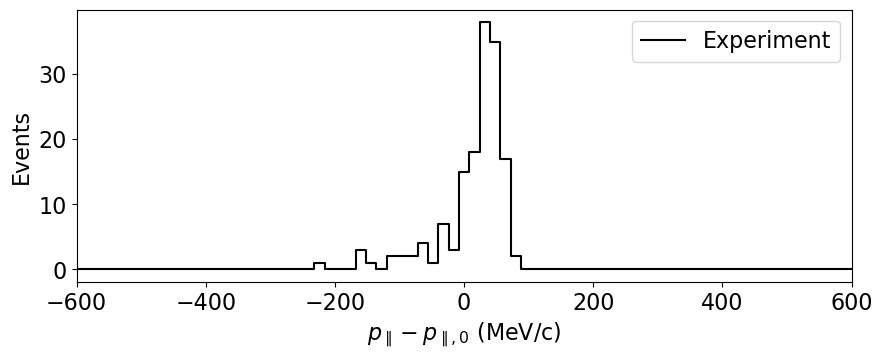

In [12]:
ppar_test.load_unreacted(file='hist_unreacted.root',
                         hist='S800_ppar/ppar-ptot0_gate_MeV_c;1',
                         rebin=8
                        )

#ppar_test.plot_unreacted(rebin=False,xlim=[-600,600]);
ppar_test.plot_unreacted(xlim=[-600,600]);

The shape is extracted by means of a fit using the piecewise defined function

$\mathcal{F}(p,a_i)=
\begin{cases}
a_1\exp(a_2p)+\mathcal{N}(p,a_3,a_4,a_5)\hspace{3cm}\forall p<a_0\\
p_6(\text{erfc}(p,-p_7,p_8,p_9)-\text{erfc}(p,p_7,p_8,p_9))\hspace{0.77cm}\forall p\geq a_0
\end{cases}$

If the *fit_unreacted* method receives start values *x0* of length ten
it will use the above fit function.
If, on the other hand, *x0* is of length seven, it will omit the Gaussian 
on the low-momentum side.
The argument 'fit_range' controls the range of the spectrum the fit function is adapted to.

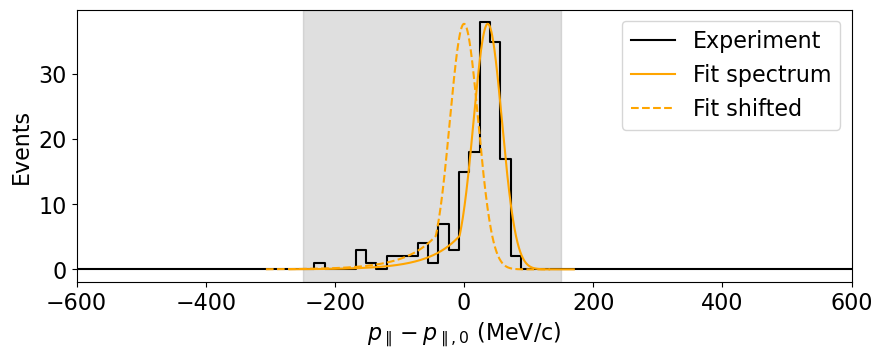

In [13]:
x0 = [-10,
      10,0.01,
      #10,0,10,
      1000,5,50,5
     ]

ppar_test.fit_unreacted(fit_range=[-250,150],x0=x0)
ppar_test.plot_unreacted(xlim=[-600,600]);

Scipy's OptimizeResult object can be accessed at *fit_res_unreac*.

In [14]:
ppar_test.fit_res_unreac

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11.227601422048803
             x: [-6.914e+00  5.948e+00  2.101e-02  3.519e+02  5.880e+00
                  3.676e+01  3.927e+00]
           nit: 1756
          nfev: 2630
 final_simplex: (array([[-6.914e+00,  5.948e+00, ...,  3.676e+01,
                         3.927e+00],
                       [-6.914e+00,  5.948e+00, ...,  3.676e+01,
                         3.927e+00],
                       ...,
                       [-6.914e+00,  5.948e+00, ...,  3.676e+01,
                         3.927e+00],
                       [-6.914e+00,  5.948e+00, ...,  3.676e+01,
                         3.927e+00]], shape=(8, 7)), array([ 1.123e+01,  1.123e+01,  1.123e+01,  1.123e+01,
                        1.123e+01,  1.123e+01,  1.123e+01,  1.123e+01]))

## Theory input

The next step is the generation of *state* objects for each state of interest.
They can conveniently be stored in a dictionary and take the above *ppar* object 
as well as the theoretical momentum distribution as input.

The input distributions can be desplayed using the *plot_theory* method.
Similar to the above introduced methods for plotting it supports the 
'rescale' (default *False*) and 'save' keywords.

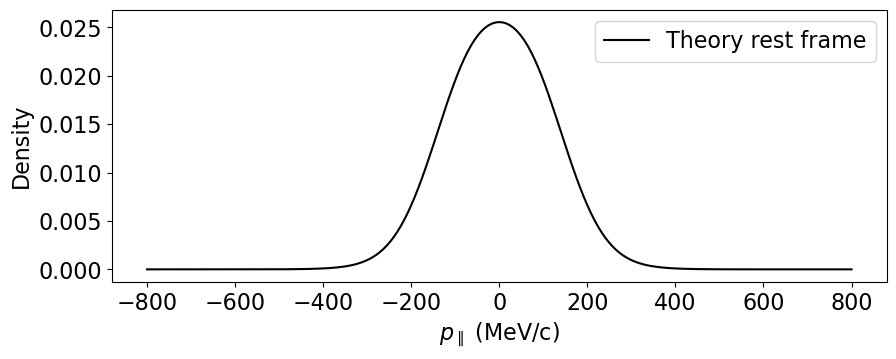

In [15]:
theo_test = {'2+':ppar.state(ppar_test,'sigl.sx2.01')}
theo_test['2+'].plot_theory();

Ultimately, the theoretical momentum distribution can be convolved with
the profile from the $\gamma$-gated $p_{\parallel}$ distribution of the unreacted beam
and a rectangular function modelling the momentum differences due to the reaction position.

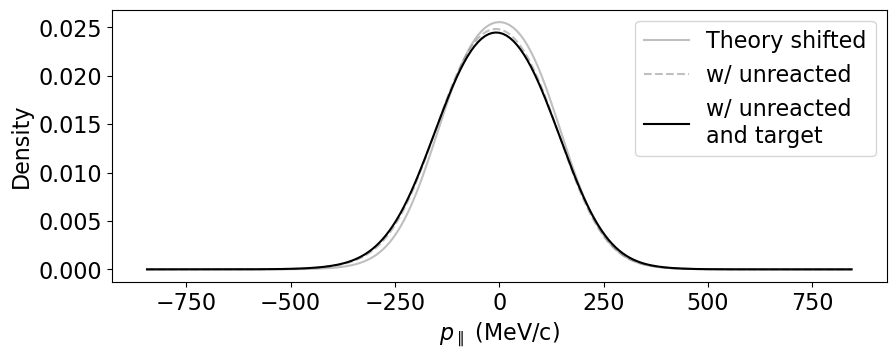

In [16]:
theo_test['2+'].convolve_theory();
theo_test['2+'].plot_theory();

The data for the different convolved momentum distributions can be accessed through *ppar_theo*
along with interpolating functions.
The comprise

- 'orig': the original theoretical momentum distribution,
- 'tail': the theoretical momentum distribution convolved with the shape obtained from the $\gamma$-gated $p_{\parallel}$ distribution of the unreacted beam,
- 'target': the theoretical momentum distribution convolved with the rectangular function modelling the momentum differences due to the reaction position, and
- 'tail_target': the theoretical momentum distribution convolved with both of the above.

In [17]:
#print(theo_test['2+'].ppar_theo['orig'])
#print(theo_test['2+'].ppar_theo['tail'])
#print(theo_test['2+'].ppar_theo['target'])
#print(theo_test['2+'].ppar_theo['tail_target'])

If the entire analysis is perfomed with python the *ppar* code offers two additional functionalities.
Exclusive parallel momentum distributions with Monte Carlo uncertainties can be 
loaded using the *rebin_hist* method. 
In this case, they need to be dictionaries with keys 'x_centers', 'x_edges', and 'values'.
The distributions can be rebinned by the factor supllied via the 'rebin' keyword (default *1*)
and expressed in terms of mode and shortest-coverage interval.

The resulting histogram can be displayed using the *plot_hist* method
which supports the 'rebin' (default *True*), 'log' (default *False*), 'rescale' (default *False*), 
'xlim', 'ylim', and 'save' keywords.

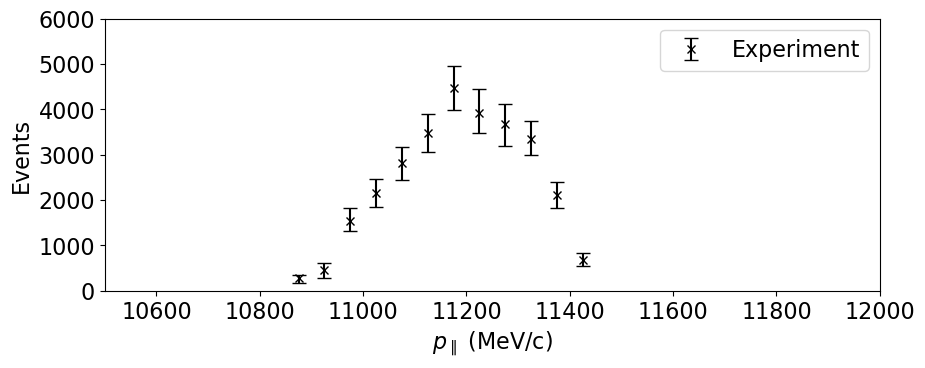

In [18]:
theo_test['2+'].rebin_hist(exp_ppar_distr,
                           rebin=5,
                          )
theo_test['2+'].plot_hist(xlim=[10500,12000],ylim=[0,6000]);

If necessary, the plot data can be accessed at *fit_res*.

In [19]:
#print(theo_test['2+'].fit_res['ind_nonzero'])
#print(theo_test['2+'].fit_res['mode'])
#print(theo_test['2+'].fit_res['sc_interval'])

Using the *fit_theory* method the convolved theoretical momentum distribution
is scaled to the content of the highest bin of the rebinned spectrum
and fitted to the part of the experimental distribution selected by 'fit_range'.

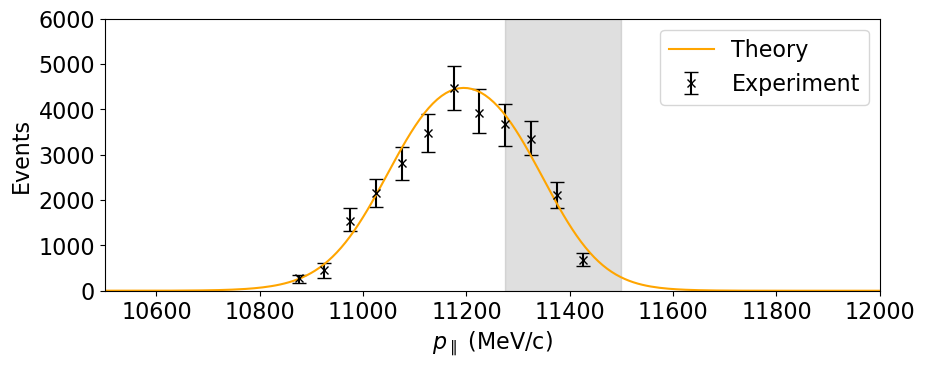

In [20]:
theo_test['2+'].fit_theory(method='x',fit_range=[11275,11500])
theo_test['2+'].plot_hist(xlim=[10500,12000],ylim=[0,6000]);

In [21]:
theo_test['2+'].fit_res

array([  495.1510513 , 11202.35065146])